# Custom CNN

We'll go over:

* Prepping input
* Sequential model
* Training the model
* Saving the model
* Saving the weights

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

Tensorflow version: 2.0.0-beta1
Keras version: 2.2.4-tf


## Prep Input

We need to define the following:

* input shape
* training data generator
* validation data generator

Most CNN's depend on a static input size in this example our input will be 160 x 160

Also make sure to notice that we are rescaling the images

In [4]:
input_shape = (160, 160, 3)

num_classes = 10

Here we are creating our training and validation data generators

This should be super simple as long as all of your images are structured correctly

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    batch_size=64,
    class_mode='categorical',
    target_size=(160, 160)
)

Found 12894 images belonging to 10 classes.


In [6]:
valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow_from_directory(
    'data/val',
    shuffle=False,
    class_mode='categorical',
    target_size=(160, 160)
)

Found 500 images belonging to 10 classes.


## Sequential Model

There are generally two types of model in the keras library, `Sequential` and `Functional`

The `Sequential` on is easier to instantiate but less flexible when creating the model structure

We'll go over `Functional` models in a later tutorial

### Layers

* Conv2D - Essentially it is just dragging some number of filters M that are of size N x N across the image
* Activation - This is basically always a relu until the final layer a relu is a type of non-linearity
* MaxPooling2D - This will downsample your image taking the highest number out of a N x N filter
* Dropout - Helps regularize your network, basically it helps with overfitting, all nodes will have an X chance of dropping out
* Flatten - This layer will take our 2D network and collapse it down to 1D
* This will add a fully connected layer this is usually done right before the final layer

Note on the final layer

The final layer uses a `softmax` finction for classification you can use the following table as guideline for your final layer:

| Problem type                            | Last-layer activation | Lost function              |
|-----------------------------------------|-----------------------|----------------------------|
| Binary classification                   | sigmoid               | binary_crossentropy        |
| Multiclass, single-label classification | softmax               | categorical_crossentropy   |
| Multiclass, multiclass classification   | sigmoid               | binary_crossentropy        |
| Regression to arbitrary values          | None                  | mse                        |
| Regression to values between 0 and 1    | sigmoid               | mse or binary_crossentropy |

In [7]:
# instantiate sequential model
model = Sequential()

# first layer always needs input shape but after that it's unecessary
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# notice how the architecture repeats but just adds more filters this is a common scheme used in CNNs
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

We can get a summary of our model with the following function:

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 160, 160, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 158, 158, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 158, 158, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 79, 79, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 79, 79, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 79, 79, 64)        1

### Compile the model

* choose and optimizer
* choose a loss function
* define some metrics to monitor

In [9]:
# We'll use RMSProp as our optimizer
opt = RMSprop()

In [10]:
model.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

### Fit the model

Here we actually 'fit' or 'train' the model

We need to pass the following:

* training generator (defined in the beginning)
* number of epochs (times you pass through the data)
* validation generator (defined in the beginning)

The best accuracy I was able to achieve without data augmentation was about %72 you can see the biggest jumps between the first 3 epochs

In [11]:
history = model.fit_generator(
    generator=train_generator,
    epochs=3,
    validation_data=valid_generator)

W0703 22:14:31.904945 140093826099008 deprecation.py:323] From /home/chris/.miniconda/envs/tf2/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
202/202 [==============================] - 52s 256ms/step - loss: 2.0662 - accuracy: 0.3154 - val_loss: 1.4759 - val_accuracy: 0.4780
Epoch 2/20
202/202 [==============================] - 42s 210ms/step - loss: 1.4240 - accuracy: 0.5310 - val_loss: 1.1005 - val_accuracy: 0.6580
Epoch 3/20
202/202 [==============================] - 42s 210ms/step - loss: 1.0980 - accuracy: 0.6460 - val_loss: 1.0226 - val_accuracy: 0.6560
Epoch 4/20
202/202 [==============================] - 42s 210ms/step - loss: 0.8559 - accuracy: 0.7274 - val_loss: 0.9006 - val_accuracy: 0.7120
Epoch 5/20
202/202 [==============================] - 42s 210ms/step - loss: 0.6437 - accuracy: 0.7986 - val_loss: 1.0811 - val_accuracy: 0.7080
Epoch 6/20
202/202 [==============================] - 42s 210ms/step - loss: 0.4772 - accuracy: 0.8506 - val_loss: 1.0779 - val_accuracy: 0.6940
Epoch 7/20
202/202 [==============================] - 42s 210ms/step - loss: 0.3348 - accuracy: 0.8927 - val_loss: 1.2586 - val_ac

## Saving your Model

below we will save both the model itself and the weights used to train it, later we'll show cases where we'll need one or the other

In [12]:
# the most common way to save your model is the following
model.save('models/custom_model.h5')
model.save_weights('models/custom_weights.h5')

In [13]:
# in case you need it as a json
with open('models/custom_architecture.json', 'w') as f:
    f.write(model.to_json())

### Plot your model

You can plot your model to an image to see a rough outline of the graph (we'll view this in tensorboard later)

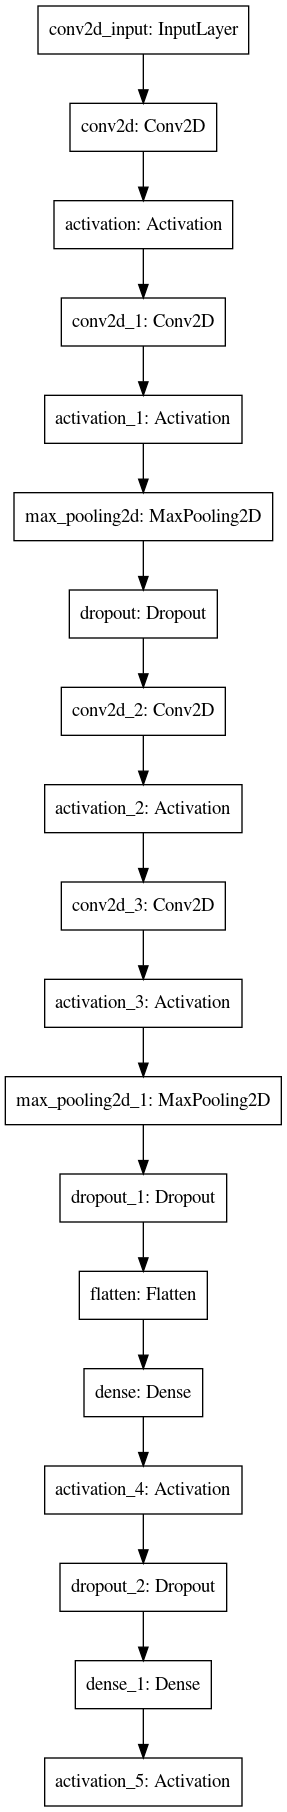

In [14]:
plot_model(model, to_file='plots/models/custom_model.png')

In [19]:
# need
# sudo apt-get install graphviz
# conda install pydot
# conda install pydotplus
# TODO get all packages needed